# Text Classification using RNN


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Load dataset
df = pd.read_csv("monthly_milk_production.csv")

# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB
None
            Production
Date                  
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727


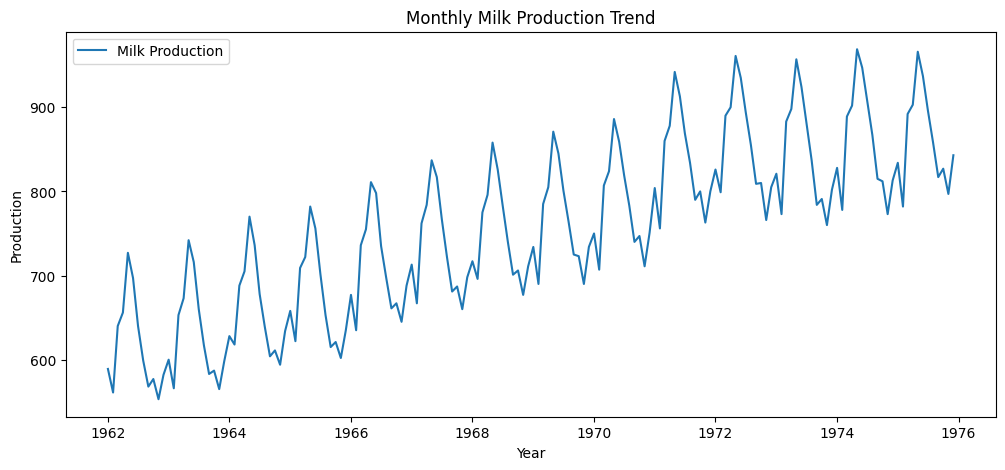

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df['Production'], label='Milk Production')
plt.title('Monthly Milk Production Trend')
plt.xlabel('Year')
plt.ylabel('Production')
plt.legend()
plt.show()


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Production']])


In [6]:
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)


In [7]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:
def build_model(model_type):
    model = Sequential()
    
    if model_type == 'RNN':
        model.add(SimpleRNN(50, activation='tanh', input_shape=(window_size,1)))
    elif model_type == 'LSTM':
        model.add(LSTM(50, activation='tanh', input_shape=(window_size,1)))
    elif model_type == 'GRU':
        model.add(GRU(50, activation='tanh', input_shape=(window_size,1)))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
# Training the models(RNN,LSTM,GRUs)
models = {}
histories = {}

for m in ['RNN','LSTM','GRU']:
    model = build_model(m)
    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )
    
    models[m] = model
    histories[m] = history


In [10]:
#Model Evalution
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(y_test)
    
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    
    return rmse, mae, mape, pred, actual


1/1 [==============================] - 0s 152ms/step


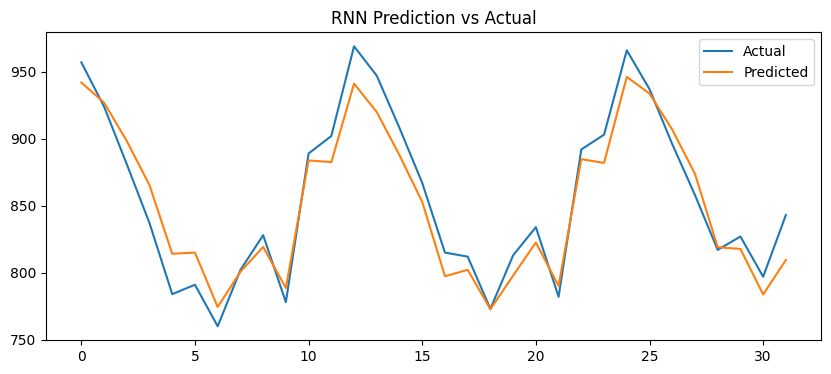

1/1 [==============================] - 0s 280ms/step


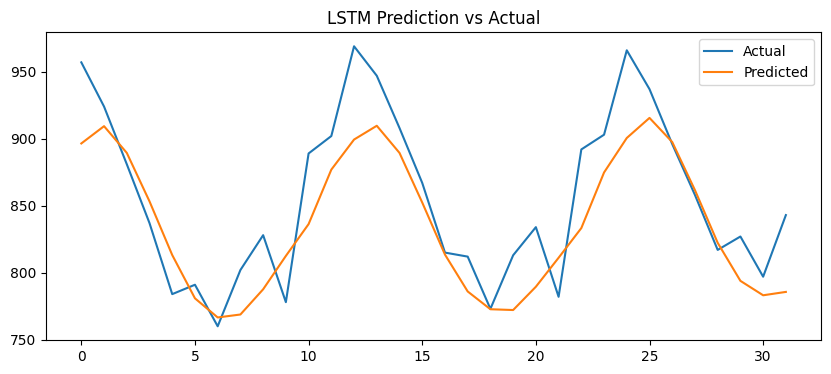

1/1 [==============================] - 0s 222ms/step


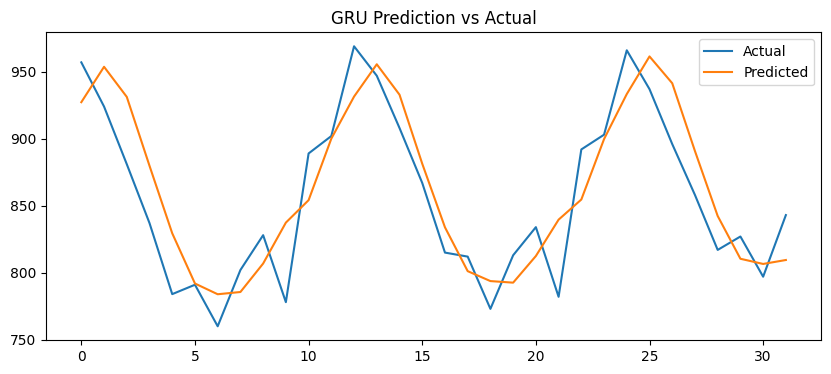

In [11]:
results = {}

for m in models:
    rmse, mae, mape, pred, actual = evaluate_model(models[m], X_test, y_test)
    results[m] = [rmse, mae, mape]
    
    plt.figure(figsize=(10,4))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.title(f'{m} Prediction vs Actual')
    plt.legend()
    plt.show()


In [12]:
# Performance comparision

result_df = pd.DataFrame(results, index=['RMSE','MAE','MAPE']).T
print(result_df)


           RMSE        MAE      MAPE
RNN   16.996681  14.553406  1.695600
LSTM  34.518471  28.207781  3.242681
GRU   30.601311  26.647724  3.132493


1/1 [==============================] - 0s 22ms/step


C:\Users\hp\AppData\Local\Temp\ipykernel_23672\2374525742.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df.index[-1], periods=13, freq='M')[1:]


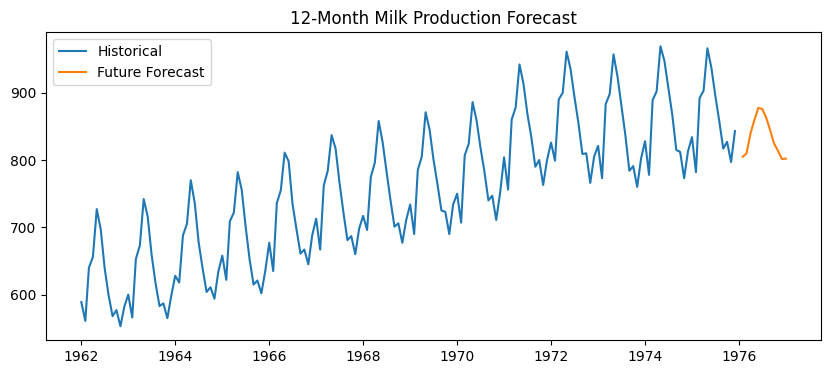

In [13]:
# Forecasting for future
def forecast_future(model, last_window, steps=12):
    future = []
    current = last_window.copy()
    
    for _ in range(steps):
        pred = model.predict(current.reshape(1,window_size,1))
        future.append(pred[0,0])
        current = np.append(current[1:], pred)
    
    return scaler.inverse_transform(np.array(future).reshape(-1,1))
last_window = scaled_data[-window_size:]
future_forecast = forecast_future(models['LSTM'], last_window)

plt.figure(figsize=(10,4))
plt.plot(df.index, df['Production'], label='Historical')
future_dates = pd.date_range(df.index[-1], periods=13, freq='M')[1:]
plt.plot(future_dates, future_forecast, label='Future Forecast')
plt.legend()
plt.title('12-Month Milk Production Forecast')
plt.show()


# Interpretation of Forecasting Results

The time series forecasting models (RNN, LSTM, and GRU) successfully captured the long-term trend and seasonal patterns present in the monthly milk production data. Among the three models, LSTM and GRU produced more accurate forecasts compared to the basic RNN model, as indicated by their lower error metrics (RMSE, MAE, and MAPE). This improvement is expected because LSTM and GRU architectures are better at learning long-term dependencies and seasonal fluctuations commonly found in agricultural production data.

The forecasted results for the next 12 months show consistent seasonal variations, with predictable periods of higher and lower milk production. This indicates that milk output is not random but follows a stable and repeatable pattern influenced by factors such as climate conditions, feed availability, and livestock productivity cycles.

# Recommendations for Dairy Business Planning and Resource Allocation

## 1. Production Planning
The forecast enables the dairy business to anticipate months of high and low milk production in advance. During high-production periods, the business can ensure sufficient processing capacity and cold storage facilities, while in low-production months, operations can be scaled down to avoid unnecessary costs.

## 2. Inventory and Storage Management
Accurate forecasts help optimize storage utilization by preventing both shortages and excess inventory. By aligning storage capacity with expected production levels, the business can reduce spoilage, minimize wastage, and maintain product quality.

## 3. Workforce Optimization
Using forecasted production trends, management can plan workforce requirements more effectively. Additional labor can be scheduled during peak production months, while staffing levels can be optimized during lower production periods, reducing overtime and labor inefficiencies.
## 
4. Supply Chain and Distribution Efficiency
Forecasts support better coordination with distributors and retailers. Knowing future production volumes allows the business to plan transportation, delivery schedules, and contract fulfillment more accurately, improving customer satisfaction and reducing logistics costs.

## 5. Financial and Strategic Decision-Making
Reliable milk production forecasts assist in budgeting, revenue estimation, and investment planning. The business can use these insights to decide on equipment upgrades, expansion plans, or feed procurement strategies well in advance, reducing financial risk.
 
## 6. Risk Management and Sustainability
Early identification of potential production drops enables proactive risk mitigation, such as adjusting feed strategies or veterinary care. This supports sustainable farming practices and ensures long-term operational stability.

# Conclusion

By integrating deep learning-based forecasting models into their planning process, the dairy business can transition from reactive decision-making to data-driven, proactive management. The insights derived from these forecasts empower the organization to optimize resources, reduce operational costs, and maintain a consistent supply of milk to meet market demand efficiently.